In [1]:
import deorbit
import numpy as np
import matplotlib.pyplot as plt
from deorbit.utils.dataio import load_sim_data, load_sim_config
from deorbit.utils.plotting import plot_trajectories, plot_height, plot_trajectories_on_map
from deorbit.observer import Observer
from deorbit.predictor import EKF

# Simulator

### Functionality

- change numerical method

In [2]:
print(f"Available sim methods: {list(deorbit.simulator.get_available_sim_methods().keys())}")

Available sim methods: ['euler', 'adams_bashforth', 'RK4']


- alter atmospheric model

In [3]:
print(f"Available atmospheric methods: {list(deorbit.simulator.get_available_atmos_models().keys())}")

Available atmospheric methods: ['zero_atmos', 'simple_atmos', 'icao_standard_atmos', 'coesa_atmos', 'coesa_atmos_fast']


- adapt noise within simulation

- set initial state -> 2D or 3D

- vary time step

In [28]:
save_path = "eg/EKF_3D/" #take care to delete this data file when making changes to initial set up

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)
sim_data = None

#this takes roughly 5 seconds
if sim_data is None or sim_config is None:
    np.random.seed(0)
    sim = deorbit.simulator.run(
        "RK4",  
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 0, 7820, 0)),
        time_step=2,
     #   noise_types = {"gaussian": {"noise_strength": 0.01}, "impulse": {"impulse_strength": 0.1, "impulse_probability": 1e-5}},
    )
    sim_data = sim.gather_data()
    sim_config = sim.export_config()
    #sim.save_data(save_path)
else:
    print("Loaded data from file")

Running simulation with RK4 integrator without noise
Ran 14722 iterations at time step of 2.0 seconds
Impacted at [-5764368.91951282 -2713211.28843511        0.        ] at velocity [ 242.67889314 -399.28526661    0.        ] at simulated time 29444.0s.
Simulation finished in 3.43750 seconds


# Outputs

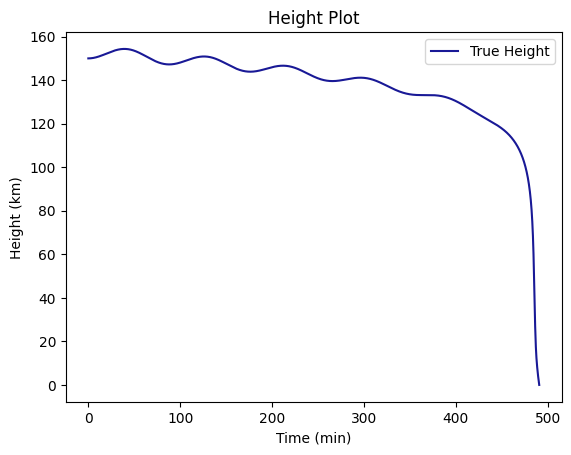

In [29]:
sim_states = sim_data.state_array()
sim_times = sim_data.times
traj = sim_data.state_array()[:, :3]
plot_height(traj, sim_times, title = 'Height Plot')

# Observer

### Functionality

In [40]:
np.random.seed(42)
obs = Observer(number_of_radars=200, dim=3, radar_position_std_per_distance=0.005)

- set number of radars

- set position of radars

- set dimension

- set std on velocity per speed, position per distance, velocity per distance

- set frequency of observations

In [41]:
obs_states, obs_times, obs_cov = obs.run(sim_states=sim_states, sim_times=sim_times, checking_interval=100)
observations = (obs_states, obs_times)

# Outputs

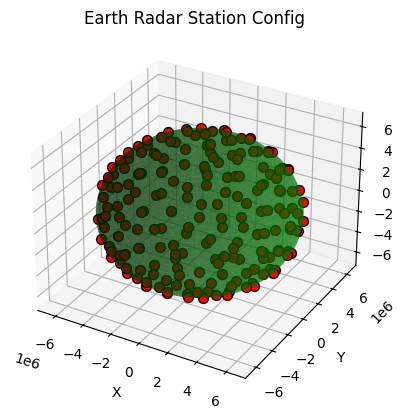

In [42]:
obs.plot_config()

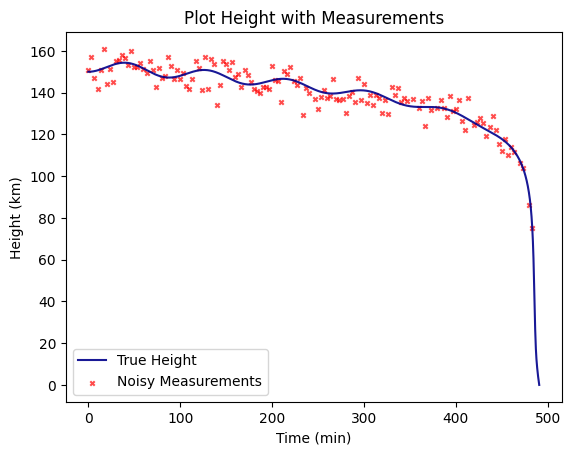

In [43]:
plot_height(traj, sim_times, observations=obs_states, observation_times = obs_times, title = 'Plot Height with Measurements')

# Predictor

### Functionality

- 2D or 3D

- uses measurements and trajectory

In [44]:
# Define process and measurement noise covariance matrices, think this noise should be alot bigger
Q = np.diag([0.1, 0.1, 0.1, 0.01, 0.01, 0.01])#process noise
P = np.eye(sim_data.state_array().shape[1]) #error covariance matrix - represents uncertainty in state estimation

# Measurement matrix H (assuming all states are measured directly)
H = np.eye(sim_data.state_array().shape[1])

dt = sim_config.simulation_method_kwargs.time_step

#initialising 3D EKF
ekf = EKF(dim=3)

estimated_traj, uncertainties, estimated_times = ekf.run(observations, dt=dt, Q=Q, R=obs_cov, P=P, H=H)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:07<00:00, 17.85it/s]


# Outputs

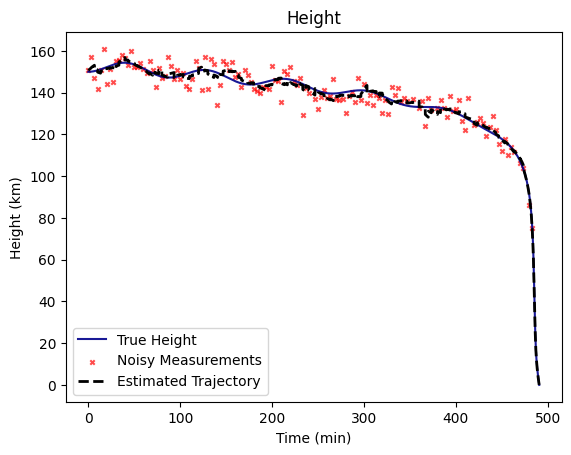

In [45]:
true_traj = sim_data.state_array()[:, :3]

plot_height(true_traj, observations=obs_states, estimated_traj=estimated_traj, observation_times=obs_times, estimated_times=estimated_times, times=sim_times)